In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
import pygad

In [ ]:
import pandas as pd

df = pd.read_csv('/content/energy_consumption_nepal_2019_2023.csv')
display(df.head())

,Year,Residential (GWh),Commercial (GWh),Industrial (GWh),Transport (GWh),Agriculture (GWh),Other (GWh),Total Electricity (GWh),Hydro (%),Solar (%),Diesel (%),"Imports (India, GWh)"
0,2019,2100,850,1700,250,150,100,5150,89,3.0,5.0,1200
1,2020,2200,900,1800,300,160,120,5480,90,3.5,4.0,950
2,2021,2350,970,1850,350,170,130,5820,91,4.2,3.5,700
3,2022,2500,1050,2000,400,180,140,6270,92,5.0,2.5,400
4,2023,2700,1100,2200,450,200,150,6800,93,5.5,1.5,150


+------------+--------------+--------------+--------------------------------------------------------------------+
| Generation | Best Fitness | Mean Fitness |                   Best Solution (First 10 Genes)                   |
+------------+--------------+--------------+--------------------------------------------------------------------+
|     1      |  -6340.7625  |  -6843.3606  | [0.71118522 0.40551394 1.62732715 0.12981638 4.43098628 3.03154275 |
|            |              |              |            0.52859984 1.38377114 4.19294175 4.65167082]            |
+------------+--------------+--------------+--------------------------------------------------------------------+
+------------+--------------+--------------+--------------------------------------------------------------------+
| Generation | Best Fitness | Mean Fitness |                   Best Solution (First 10 Genes)                   |
+------------+--------------+--------------+--------------------------------------------

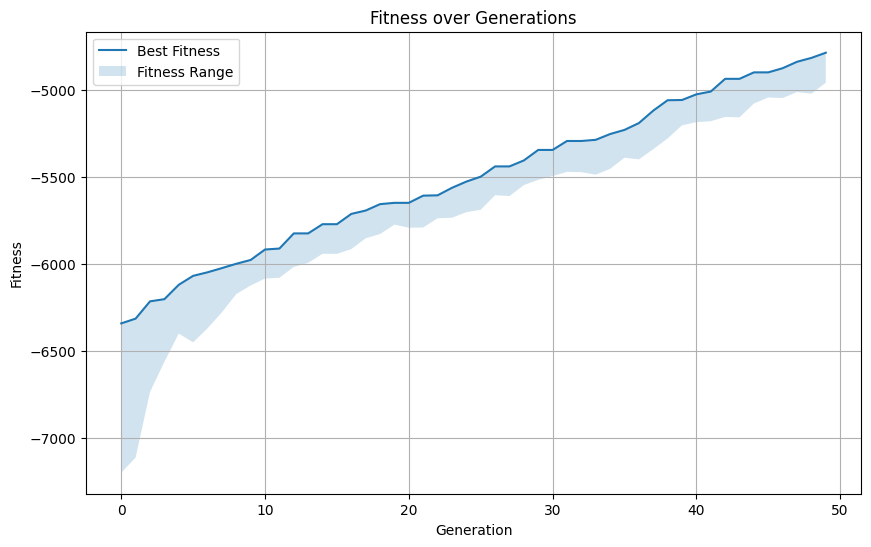

In [ ]:
# --- Grid Setup ---
sources = ['Hydro', 'Solar', 'Diesel', 'Import']
nodes = ['Residential', 'Commercial', 'Industrial']
hours = 24

num_genes = len(sources) * len(nodes) * hours

# --- Cost and Loss Factors ---
costs = {'Hydro': 2, 'Solar': 1.5, 'Diesel': 5, 'Import': 3}
losses = {'Hydro': 0.05, 'Solar': 0.03, 'Diesel': 0.08, 'Import': 0.06}

# --- Hourly Demand (GWh) ---
demand_per_hour = {
    'Residential': np.full(hours, 100 / hours),
    'Commercial': np.full(hours, 50 / hours),
    'Industrial': np.full(hours, 80 / hours),
}

# --- Decode Chromosome ---
def decode_chromosome(chromosome):
    decoded = {}
    idx = 0
    for h in range(hours):
        decoded[h] = {}
        for n in nodes:
            decoded[h][n] = {}
            for s in sources:
                decoded[h][n][s] = chromosome[idx]
                idx += 1
    return decoded

# --- Fitness Function ---
def fitness_function(ga_instance, chromosome, solution_idx):
    decoded = decode_chromosome(chromosome)
    total_cost, total_loss, unmet_demand = 0, 0, 0

    for h in range(hours):
        for n in nodes:
            supplied = sum(decoded[h][n][s] for s in sources)
            demand = demand_per_hour[n][h]
            unmet_demand += abs(demand - supplied)
            for s in sources:
                energy = decoded[h][n][s]
                total_cost += energy * costs[s]
                total_loss += energy * losses[s]

    alpha, beta, gamma = 1.0, 10.0, 5.0
    return - (alpha * total_cost + beta * unmet_demand + gamma * total_loss)

# Function to print GA progress in a table
def on_generation(ga_instance):
    table = PrettyTable()
    table.field_names = ["Generation", "Best Fitness", "Mean Fitness", "Best Solution (First 10 Genes)"]

    generation = ga_instance.generations_completed
    # Check if last_generation_fitness is available from on_start
    if hasattr(ga_instance, 'last_generation_fitness') and ga_instance.last_generation_fitness is not None:
        best_fitness_gen = max(ga_instance.last_generation_fitness)
        mean_fitness_gen = np.mean(ga_instance.last_generation_fitness)
        best_solution_gen = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[0][:10]
    else:
        # Fallback to default pygad fitness if on_start didn't run or failed
        best_fitness_gen = ga_instance.best_solution()[1]
        mean_fitness_gen = np.mean(ga_instance.last_generation_fitness) # This might still cause issues if not populated
        best_solution_gen = ga_instance.best_solution()[0][:10]


    table.add_row([generation, f"{best_fitness_gen:.4f}", f"{mean_fitness_gen:.4f}", best_solution_gen])
    print(table)

    # Store the fitness values for each generation
    if not hasattr(ga_instance, 'all_generations_best_fitness'):
        ga_instance.all_generations_best_fitness = []
        ga_instance.all_generations_min_fitness = []
        ga_instance.all_generations_max_fitness = []

    if hasattr(ga_instance, 'last_generation_fitness') and ga_instance.last_generation_fitness is not None:
        ga_instance.all_generations_best_fitness.append(best_fitness_gen)
        ga_instance.all_generations_min_fitness.append(min(ga_instance.last_generation_fitness))
        ga_instance.all_generations_max_fitness.append(max(ga_instance.last_generation_fitness))
    else:
         # If parallel evaluation was not used, pygad stores fitness in best_solutions_fitness and related attributes
         if hasattr(ga_instance, 'best_solutions_fitness'):
             ga_instance.all_generations_best_fitness.append(ga_instance.best_solutions_fitness[-1])
             ga_instance.all_generations_min_fitness.append(min(ga_instance.best_solutions_fitness))
             ga_instance.all_generations_max_fitness.append(max(ga_instance.best_solutions_fitness))
         else:
             pass

# === Inject Fitness into GA at Start ===
def on_start(ga_instance):
    fitnesses = parallel_fitness_evaluation(ga_instance.population)
    ga_instance.last_generation_fitness = fitnesses

# --- Custom Crossover Function (1-point) ---
def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    for _ in range(offspring_size[0]):
        p1, p2 = random.sample(range(len(parents)), 2)
        crossover_point = random.randint(1, ga_instance.num_genes - 1)
        child = np.concatenate((parents[p1][:crossover_point], parents[p2][crossover_point:]))
        offspring.append(child)
    return np.array(offspring)

# --- Custom Mutation Function ---
def mutation_func(offspring, ga_instance):
    for i in range(offspring.shape[0]):
        for gene_idx in range(offspring.shape[1]):
            if random.random() < 0.05:  # 5% mutation rate
                delta = random.uniform(-1, 1)
                offspring[i][gene_idx] = max(0, offspring[i][gene_idx] + delta)
    return offspring


# --- Genetic Algorithm Setup ---
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5},
    crossover_type=crossover_func,
    mutation_type=mutation_func,
    on_generation=on_generation, # Add the callback here
    stop_criteria=["saturate_10"]
)

# --- Run GA ---
ga_instance.run()

# --- Output Best Solution ---
solution, fitness, _ = ga_instance.best_solution()
print("Best Fitness:", fitness)
print("First 10 genes of solution:", solution[:10])

#Get the stored fitness values from the instance that just ran
fitness_values_plot = ga_instance.all_generations_best_fitness
min_fitness_plot = ga_instance.all_generations_min_fitness
max_fitness_plot = ga_instance.all_generations_max_fitness


#Plot the fitness values
plt.figure(figsize=(10, 6))
plt.plot(fitness_values_plot, label="Best Fitness")

# # Plot the range
plt.fill_between(range(len(fitness_values_plot)), min_fitness_plot, max_fitness_plot, alpha=0.2, label='Fitness Range')


plt.title("Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import multiprocessing
import random

# === Grid Parameters ===
sources = ['Hydro', 'Solar', 'Diesel', 'Import']
nodes = ['Residential', 'Commercial', 'Industrial']
hours = 24
num_genes = len(sources) * len(nodes) * hours  # 4x3x24 = 288

# === Cost and Loss Factors ===
costs = {'Hydro': 2, 'Solar': 1.5, 'Diesel': 5, 'Import': 3}
losses = {'Hydro': 0.05, 'Solar': 0.03, 'Diesel': 0.08, 'Import': 0.06}

# === Simulated Hourly Demand per Node ===
demand_per_hour = {
    'Residential': np.full(hours, 100 / hours),
    'Commercial': np.full(hours, 50 / hours),
    'Industrial': np.full(hours, 80 / hours),
}

# === Decode Chromosome into {hour: {node: {source: value}}} ===
def decode_chromosome(chromosome):
    decoded = {}
    idx = 0
    for h in range(hours):
        decoded[h] = {}
        for n in nodes:
            decoded[h][n] = {}
            for s in sources:
                decoded[h][n][s] = chromosome[idx]
                idx += 1
    return decoded

# === Fitness Function (Used in Multiprocessing) ===
def fitness_function(ga_instance, chromosome, solution_idx):
    decoded = decode_chromosome(chromosome)
    total_cost = 0
    total_loss = 0
    unmet_demand = 0

    for h in range(hours):
        for n in nodes:
            supplied = sum(decoded[h][n][s] for s in sources)
            demand = demand_per_hour[n][h]
            unmet_demand += abs(demand - supplied)
            for s in sources:
                energy = decoded[h][n][s]
                total_cost += energy * costs[s]
                total_loss += energy * losses[s]

    alpha, beta, gamma = 1.0, 10.0, 5.0
    return - (alpha * total_cost + beta * unmet_demand + gamma * total_loss)

# === Parallel Fitness Evaluation ===
def parallel_fitness_evaluation(population):
    with multiprocessing.Pool() as pool:
        fitness_values = pool.starmap(fitness_function, [(None, ind, i) for i, ind in enumerate(population)]) # Pass None for ga_instance
    return fitness_values

# === Inject Fitness into GA at Start ===
def on_start(ga_instance):
    fitnesses = parallel_fitness_evaluation(ga_instance.population)
    ga_instance.last_generation_fitness = fitnesses

# Function to print GA progress in a table
def on_generation(ga_instance):
    table = PrettyTable()
    table.field_names = ["Generation", "Best Fitness", "Mean Fitness", "Best Solution (First 10 Genes)"]

    generation = ga_instance.generations_completed
    # Check if last_generation_fitness is available from on_start
    if hasattr(ga_instance, 'last_generation_fitness') and ga_instance.last_generation_fitness is not None:
        best_fitness_gen = max(ga_instance.last_generation_fitness)
        mean_fitness_gen = np.mean(ga_instance.last_generation_fitness)
        best_solution_gen = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[0][:10]
    else:
        # Fallback to default pygad fitness if on_start didn't run or failed
        best_fitness_gen = ga_instance.best_solution()[1]
        mean_fitness_gen = np.mean(ga_instance.last_generation_fitness) # This might still cause issues if not populated
        best_solution_gen = ga_instance.best_solution()[0][:10]


    table.add_row([generation, f"{best_fitness_gen:.4f}", f"{mean_fitness_gen:.4f}", best_solution_gen])
    print(table)

    # Store the fitness values for each generation
    if not hasattr(ga_instance, 'all_generations_best_fitness'):
        ga_instance.all_generations_best_fitness = []
        ga_instance.all_generations_min_fitness = []
        ga_instance.all_generations_max_fitness = []

    if hasattr(ga_instance, 'last_generation_fitness') and ga_instance.last_generation_fitness is not None:
        ga_instance.all_generations_best_fitness.append(best_fitness_gen)
        ga_instance.all_generations_min_fitness.append(min(ga_instance.last_generation_fitness))
        ga_instance.all_generations_max_fitness.append(max(ga_instance.last_generation_fitness))
    else:
         # If parallel evaluation was not used, pygad stores fitness in best_solutions_fitness and related attributes
         if hasattr(ga_instance, 'best_solutions_fitness'):
             ga_instance.all_generations_best_fitness.append(ga_instance.best_solutions_fitness[-1])
             ga_instance.all_generations_min_fitness.append(min(ga_instance.best_solutions_fitness))
             ga_instance.all_generations_max_fitness.append(max(ga_instance.best_solutions_fitness))
         else:
             pass


# === Custom Crossover ===
def crossover_func(parents, offspring_size, ga_instance):
    offspring = []
    for _ in range(offspring_size[0]):
        p1, p2 = random.sample(range(len(parents)), 2)
        crossover_point = random.randint(1, ga_instance.num_genes - 1)
        child = np.concatenate((parents[p1][:crossover_point], parents[p2][crossover_point:]))
        offspring.append(child)
    return np.array(offspring)

# === Custom Mutation ===
def mutation_func(offspring, ga_instance):
    for i in range(offspring.shape[0]):
        for j in range(offspring.shape[1]):
            if random.random() < 0.05:  # 5% chance
                delta = random.uniform(-1, 1)
                offspring[i][j] = max(0, offspring[i][j] + delta)
    return offspring

Starting Genetic Algorithm...
+------------+--------------+--------------+--------------------------------------------------------------------+
| Generation | Best Fitness | Mean Fitness |                   Best Solution (First 10 Genes)                   |
+------------+--------------+--------------+--------------------------------------------------------------------+
|     1      |  -6213.1517  |  -6696.5858  | [0.61763341 1.25924987 2.61526239 2.05766349 0.86941057 1.53659847 |
|            |              |              |            3.62194844 4.32074493 4.18648497 1.21457279]            |
+------------+--------------+--------------+--------------------------------------------------------------------+
+------------+--------------+--------------+--------------------------------------------------------------------+
| Generation | Best Fitness | Mean Fitness |                   Best Solution (First 10 Genes)                   |
+------------+--------------+--------------+--------------

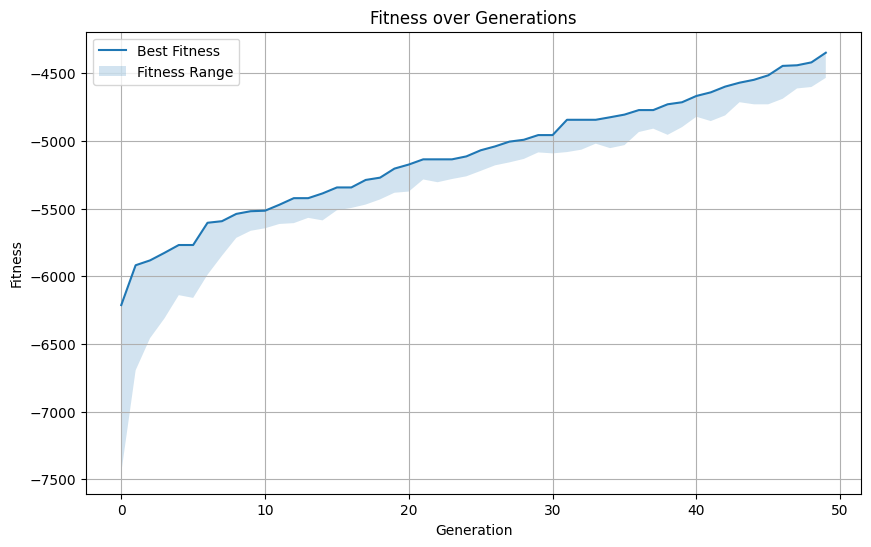

In [ ]:
# log for parallel and display clean table

# === GA Setup with on_generation callback ===
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5},
    mutation_percent_genes=5,
    mutation_type=mutation_func,
    crossover_type=crossover_func,
    on_start=on_start,
    on_generation=on_generation,  # Add the callback here
    stop_criteria=["saturate_10"]
)

# === Run the GA ===
print("Starting Genetic Algorithm...")
ga_instance.run()

# === Best Result ===
solution, fitness, _ = ga_instance.best_solution()
print("\nGA Run Finished.")
print("Final Best Fitness:", fitness)
print("Final Best Solution (First 10 genes):", solution[:10])

# Get the stored fitness values
fitness_values_plot = ga_instance.all_generations_best_fitness
min_fitness_plot = ga_instance.all_generations_min_fitness
max_fitness_plot = ga_instance.all_generations_max_fitness


# Plot the fitness values
plt.figure(figsize=(10, 6))
plt.plot(fitness_values_plot, label="Best Fitness")

# Plot the range
plt.fill_between(range(len(fitness_values_plot)), min_fitness_plot, max_fitness_plot, alpha=0.2, label='Fitness Range')


plt.title("Fitness over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()

--- Running Serial GA ---

Serial GA Duration: 0.4067 seconds
Serial Best Fitness: -4542.761642902614

--- Running Parallel GA ---

Parallel GA Duration: 0.4232 seconds
Parallel Best Fitness: -4216.049560304018

--- Comparison ---
+-------------+--------------------+--------------+
|  Algorithm  | Duration (seconds) | Best Fitness |
+-------------+--------------------+--------------+
|  Serial GA  |       0.4067       |  -4542.7616  |
| Parallel GA |       0.4232       |  -4216.0496  |
+-------------+--------------------+--------------+


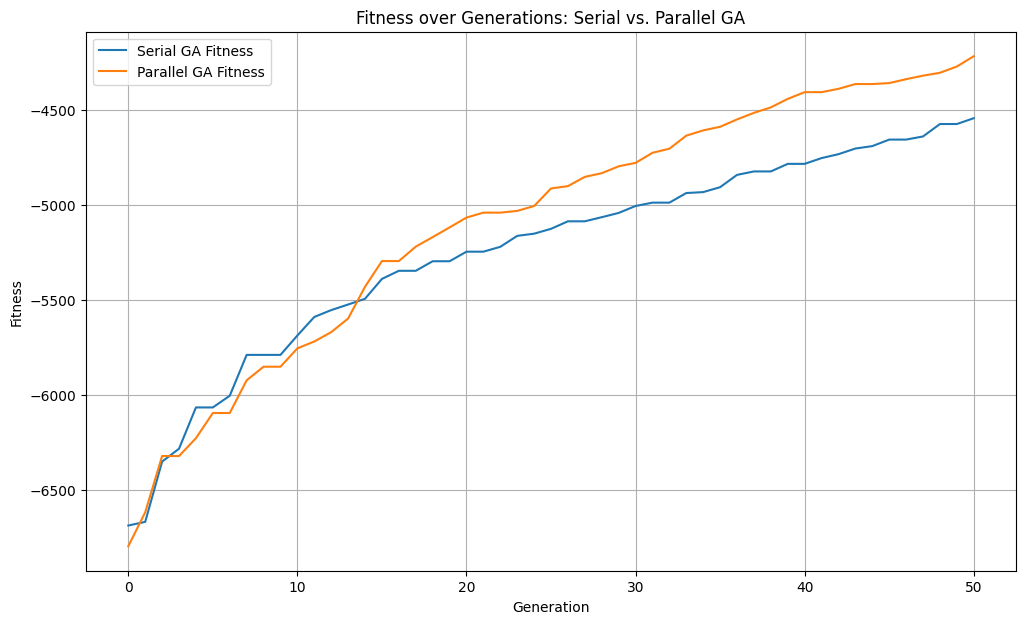

In [ ]:
# code to compare serail and parallel

import time

# --- Serial GA Setup and Run ---
print("--- Running Serial GA ---")
ga_instance_serial = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5},
    mutation_percent_genes=5,
    mutation_type=mutation_func,
    crossover_type=crossover_func,
    stop_criteria=["saturate_10"]
)

start_time_serial = time.time()
ga_instance_serial.run()
end_time_serial = time.time()
serial_duration = end_time_serial - start_time_serial

print(f"\nSerial GA Duration: {serial_duration:.4f} seconds")
print("Serial Best Fitness:", ga_instance_serial.best_solution()[1])


# --- Parallel GA Setup and Run ---
print("\n--- Running Parallel GA ---")
ga_instance_parallel = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,  # required by pygad, but results are replaced
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5},
    mutation_percent_genes=5,
    mutation_type=mutation_func,
    crossover_type=crossover_func,
    on_start=on_start, # Use parallel evaluation
    stop_criteria=["saturate_10"]
)

start_time_parallel = time.time()
ga_instance_parallel.run()
end_time_parallel = time.time()
parallel_duration = end_time_parallel - start_time_parallel

print(f"\nParallel GA Duration: {parallel_duration:.4f} seconds")
print("Parallel Best Fitness:", ga_instance_parallel.best_solution()[1])

# --- Comparison ---
print("\n--- Comparison ---")
table_comparison = PrettyTable()
table_comparison.field_names = ["Algorithm", "Duration (seconds)", "Best Fitness"]
table_comparison.add_row(["Serial GA", f"{serial_duration:.4f}", f"{ga_instance_serial.best_solution()[1]:.4f}"])
table_comparison.add_row(["Parallel GA", f"{parallel_duration:.4f}", f"{ga_instance_parallel.best_solution()[1]:.4f}"])
print(table_comparison)

# Plotting the fitness comparison
plt.figure(figsize=(12, 7))
plt.plot(ga_instance_serial.best_solutions_fitness, label="Serial GA Fitness")
plt.plot(ga_instance_parallel.best_solutions_fitness, label="Parallel GA Fitness")
plt.title("Fitness over Generations: Serial vs. Parallel GA")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()

Rule Based Algorithm


--- Running Rule-Based Baseline ---
Rule-Based Duration: 0.0003 seconds
Rule-Based Total Cost: 345.00
Rule-Based Total Loss: 6.90
Rule-Based Unmet Demand: 0.00
Rule-Based Objective Value (Fitness): -379.5000

--- Running GA for Comparison ---

GA Duration: 0.3948 seconds
GA Best Fitness: -4275.1267
GA Total Cost (Best Solution): 1348.12
GA Total Loss (Best Solution): 26.55
GA Unmet Demand (Best Solution): 279.43

--- GA vs. Rule-Based Comparison ---
+-------------------+--------------------+---------------------------+------------+------------+--------------+
|       Method      | Duration (seconds) | Objective Value (Fitness) | Total Cost | Total Loss | Unmet Demand |
+-------------------+--------------------+---------------------------+------------+------------+--------------+
|     Rule-Based    |       0.0003       |         -379.5000         |   345.00   |    6.90    |     0.00     |
| Genetic Algorithm |       0.3948       |         -4275.1267        |  1348.12   |   26.55    | 

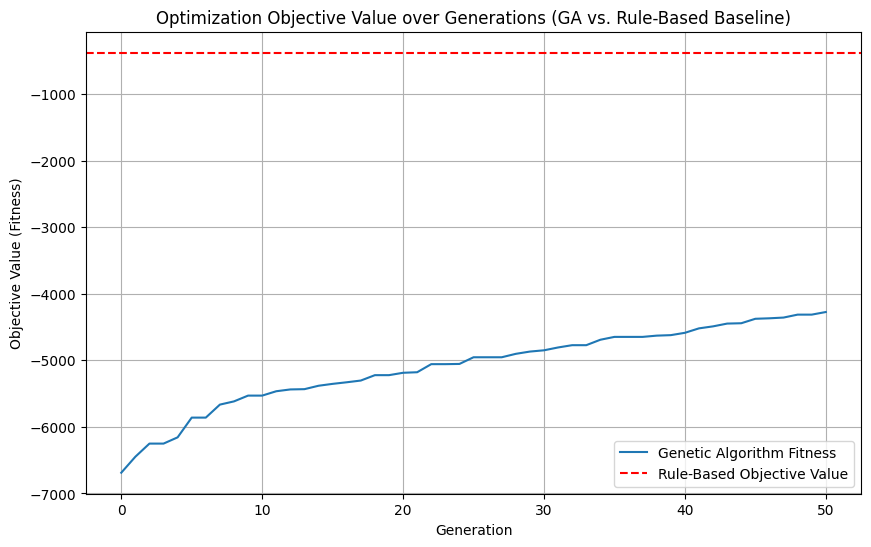

In [ ]:
#Compare GA based optimization to any baseline method (rule based)

# --- Rule-Based Baseline ---
def rule_based_optimization(demand_per_hour, costs, losses, sources, nodes, hours):
    """
    Implements a simple rule-based approach for energy allocation.
    Prioritizes cheaper sources first.
    """
    allocation = {}
    total_cost = 0
    total_loss = 0
    unmet_demand = 0

    # Sort sources by cost (cheapest first)
    sorted_sources = sorted(costs.items(), key=lambda item: item[1])

    for h in range(hours):
        allocation[h] = {}
        for n in nodes:
            allocation[h][n] = {}
            remaining_demand = demand_per_hour[n][h]
            supplied = 0

            for s, cost in sorted_sources:
                # Allocate as much as possible from the current source
                # Simple assumption: unlimited capacity per source for baseline
                amount_to_allocate = remaining_demand
                allocation[h][n][s] = amount_to_allocate
                supplied += amount_to_allocate
                total_cost += amount_to_allocate * costs[s]
                total_loss += amount_to_allocate * losses[s]
                remaining_demand -= amount_to_allocate # This will become 0 after the first source handles it unless capacities are limited

            unmet_demand += abs(demand_per_hour[n][h] - supplied) # Should be 0 with unlimited capacity

    # Calculate the objective function value for the rule-based solution
    alpha, beta, gamma = 1.0, 10.0, 5.0
    rule_based_objective = - (alpha * total_cost + beta * unmet_demand + gamma * total_loss) # Maximize is best

    return total_cost, total_loss, unmet_demand, rule_based_objective, allocation

# --- Run Rule-Based Baseline ---
print("\n--- Running Rule-Based Baseline ---")
start_time_rule_based = time.time()
rule_based_cost, rule_based_loss, rule_based_unmet_demand, rule_based_objective, rule_based_allocation = rule_based_optimization(
    demand_per_hour, costs, losses, sources, nodes, hours
)
end_time_rule_based = time.time()
rule_based_duration = end_time_rule_based - start_time_rule_based

print(f"Rule-Based Duration: {rule_based_duration:.4f} seconds")
print(f"Rule-Based Total Cost: {rule_based_cost:.2f}")
print(f"Rule-Based Total Loss: {rule_based_loss:.2f}")
print(f"Rule-Based Unmet Demand: {rule_based_unmet_demand:.2f}")
print(f"Rule-Based Objective Value (Fitness): {rule_based_objective:.4f}")


# --- Run GA again for a clean comparison ---
# Use the previously defined ga_instance with serial evaluation
print("\n--- Running GA for Comparison ---")
ga_instance_comparison = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5}, # Gene space allows for variation
    mutation_percent_genes=5,
    mutation_type=mutation_func,
    crossover_type=crossover_func,
    stop_criteria=["saturate_10"]
)

start_time_ga_comparison = time.time()
ga_instance_comparison.run()
end_time_ga_comparison = time.time()
ga_duration_comparison = end_time_ga_comparison - start_time_ga_comparison

ga_best_solution, ga_best_fitness, _ = ga_instance_comparison.best_solution()

# Decode GA's best solution to calculate cost, loss, unmet demand
decoded_ga_solution = decode_chromosome(ga_best_solution)
ga_total_cost, ga_total_loss, ga_unmet_demand = 0, 0, 0

for h in range(hours):
    for n in nodes:
        supplied = sum(decoded_ga_solution[h][n][s] for s in sources)
        demand = demand_per_hour[n][h]
        ga_unmet_demand += abs(demand - supplied)
        for s in sources:
            energy = decoded_ga_solution[h][n][s]
            ga_total_cost += energy * costs[s]
            ga_total_loss += energy * losses[s]


print(f"\nGA Duration: {ga_duration_comparison:.4f} seconds")
print(f"GA Best Fitness: {ga_best_fitness:.4f}")
print(f"GA Total Cost (Best Solution): {ga_total_cost:.2f}")
print(f"GA Total Loss (Best Solution): {ga_total_loss:.2f}")
print(f"GA Unmet Demand (Best Solution): {ga_unmet_demand:.2f}")


# --- Comparison Table ---
print("\n--- GA vs. Rule-Based Comparison ---")
comparison_table = PrettyTable()
comparison_table.field_names = ["Method", "Duration (seconds)", "Objective Value (Fitness)", "Total Cost", "Total Loss", "Unmet Demand"]

comparison_table.add_row([
    "Rule-Based",
    f"{rule_based_duration:.4f}",
    f"{rule_based_objective:.4f}",
    f"{rule_based_cost:.2f}",
    f"{rule_based_loss:.2f}",
    f"{rule_based_unmet_demand:.2f}"
])

comparison_table.add_row([
    "Genetic Algorithm",
    f"{ga_duration_comparison:.4f}",
    f"{ga_best_fitness:.4f}",
    f"{ga_total_cost:.2f}",
    f"{ga_total_loss:.2f}",
    f"{ga_unmet_demand:.2f}"
])

print(comparison_table)


# --- Plotting Fitness Comparison (Optional) ---
# Note: Rule-based doesn't have "generations" or fitness progression in the same way
# We can compare the final objective value directly.
# If you want to visualize GA's progression vs a fixed baseline, you can plot GA fitness over generations
# and draw a horizontal line at the rule-based objective value.

plt.figure(figsize=(10, 6))
plt.plot(ga_instance_comparison.best_solutions_fitness, label="Genetic Algorithm Fitness")
plt.axhline(y=rule_based_objective, color='r', linestyle='--', label="Rule-Based Objective Value")
plt.title("Optimization Objective Value over Generations (GA vs. Rule-Based Baseline)")
plt.xlabel("Generation")
plt.ylabel("Objective Value (Fitness)") # Higher is better
plt.legend()
plt.grid(True)
plt.show()

Plotting Overall Result

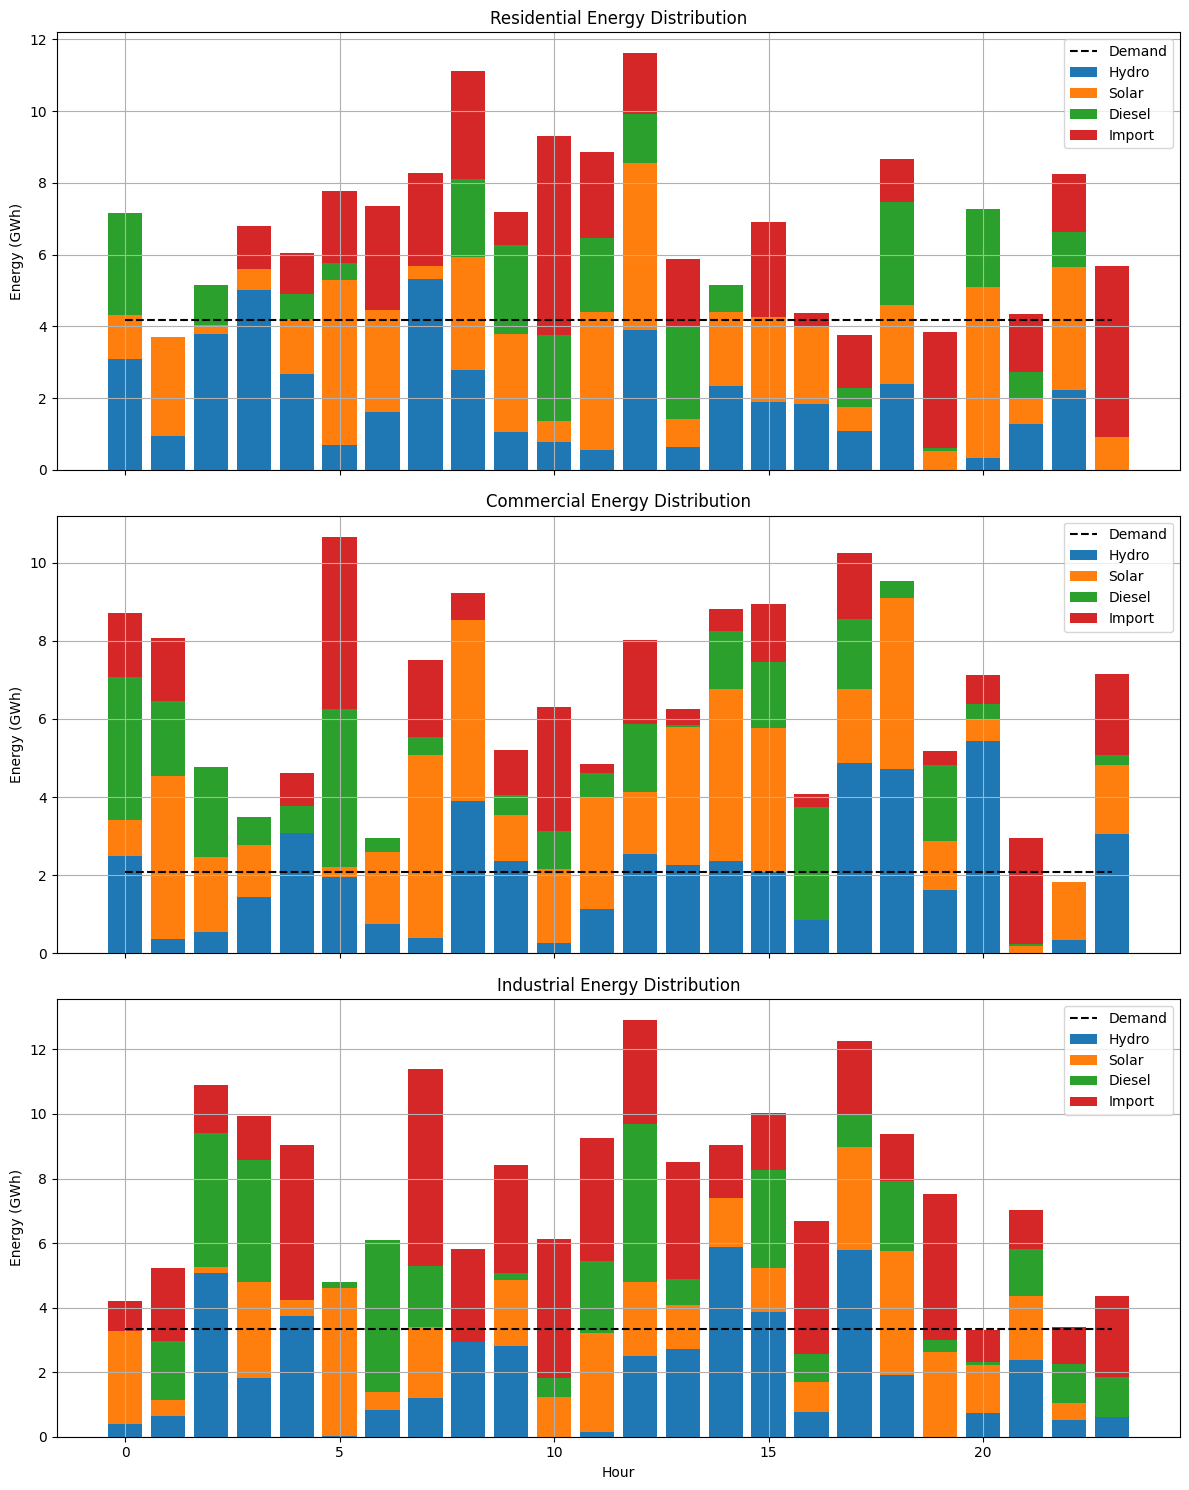

In [ ]:
# --- Decode and Visualize Best Solution ---
best_solution_decoded = decode_chromosome(solution)

# Prepare data for plotting
residential_energy = {s: [] for s in sources}
commercial_energy = {s: [] for s in sources}
industrial_energy = {s: [] for s in sources}

for h in range(hours):
    for s in sources:
        residential_energy[s].append(best_solution_decoded[h]['Residential'][s])
        commercial_energy[s].append(best_solution_decoded[h]['Commercial'][s])
        industrial_energy[s].append(best_solution_decoded[h]['Industrial'][s])

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), sharex=True)

# Residential
bottom_residential = np.zeros(hours)
for s in sources:
    axes[0].bar(range(hours), residential_energy[s], bottom=bottom_residential, label=s)
    bottom_residential += residential_energy[s]
axes[0].plot(range(hours), demand_per_hour['Residential'], color='black', linestyle='--', label='Demand')
axes[0].set_title('Residential Energy Distribution')
axes[0].set_ylabel('Energy (GWh)')
axes[0].legend()
axes[0].grid(True)

# Commercial
bottom_commercial = np.zeros(hours)
for s in sources:
    axes[1].bar(range(hours), commercial_energy[s], bottom=bottom_commercial, label=s)
    bottom_commercial += commercial_energy[s]
axes[1].plot(range(hours), demand_per_hour['Commercial'], color='black', linestyle='--', label='Demand')
axes[1].set_title('Commercial Energy Distribution')
axes[1].set_ylabel('Energy (GWh)')
axes[1].legend()
axes[1].grid(True)

# Industrial
bottom_industrial = np.zeros(hours)
for s in sources:
    axes[2].bar(range(hours), industrial_energy[s], bottom=bottom_industrial, label=s)
    bottom_industrial += industrial_energy[s]
axes[2].plot(range(hours), demand_per_hour['Industrial'], color='black', linestyle='--', label='Demand')
axes[2].set_title('Industrial Energy Distribution')
axes[2].set_ylabel('Energy (GWh)')
axes[2].set_xlabel('Hour')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Implement cpu monitoring




In [ ]:
import psutil
import time

def get_cpu_usage():
    """Returns the current CPU usage percentage."""
    return psutil.cpu_percent(interval=None)


In [ ]:
# --- Serial GA Setup and Run ---
print("--- Running Serial GA ---")
serial_cpu_usage = []
start_time_serial = time.time()
serial_cpu_usage.append((time.time(), get_cpu_usage()))

ga_instance_serial = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5},
    mutation_percent_genes=5,
    mutation_type=mutation_func,
    crossover_type=crossover_func,

    stop_criteria=["saturate_10"]
)

# Simple monitoring loop during serial run - adjust interval as needed
monitor_interval = 0.1
def serial_monitor():
    while time.time() - start_time_serial < ga_instance_serial.num_generations * 0.1: # Arbitrary duration estimate
        serial_cpu_usage.append((time.time(), get_cpu_usage()))
        time.sleep(monitor_interval)

serial_cpu_usage.append((time.time(), get_cpu_usage())) # After GA instance setup

ga_instance_serial.run()

end_time_serial = time.time()
serial_cpu_usage.append((time.time(), get_cpu_usage())) # After GA run
serial_duration = end_time_serial - start_time_serial

print(f"\nSerial GA Duration: {serial_duration:.4f} seconds")
print("Serial Best Fitness:", ga_instance_serial.best_solution()[1])


# --- Parallel GA Setup and Run ---
print("\n--- Running Parallel GA ---")
parallel_cpu_usage = []
start_time_parallel = time.time()
parallel_cpu_usage.append((time.time(), get_cpu_usage()))

ga_instance_parallel = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=num_genes,
    gene_space={'low': 0, 'high': 5},
    mutation_percent_genes=5,
    mutation_type=mutation_func,
    on_start=on_start,
    stop_criteria=["saturate_10"]
)

parallel_cpu_usage.append((time.time(), get_cpu_usage())) # After GA instance setup

ga_instance_parallel.run()

end_time_parallel = time.time()
parallel_cpu_usage.append((time.time(), get_cpu_usage())) # After GA run
parallel_duration = end_time_parallel - start_time_parallel

print(f"\nParallel GA Duration: {parallel_duration:.4f} seconds")
print("Parallel Best Fitness:", ga_instance_parallel.best_solution()[1])

# The collected CPU usage data is now stored in serial_cpu_usage and parallel_cpu_usage.
# The next subtask would be to process and include this data in the comparison.

--- Running Serial GA ---

Serial GA Duration: 0.4565 seconds
Serial Best Fitness: -4670.993064101488

--- Running Parallel GA ---

Parallel GA Duration: 0.4893 seconds
Parallel Best Fitness: -4533.901706785949


In [ ]:
import pandas as pd

# Convert lists to DataFrames
serial_cpu_df = pd.DataFrame(serial_cpu_usage, columns=['Time', 'CPU Usage'])
parallel_cpu_df = pd.DataFrame(parallel_cpu_usage, columns=['Time', 'CPU Usage'])

# Adjust Time to be relative to the start of each run
serial_cpu_df['Time'] = serial_cpu_df['Time'] - serial_cpu_df['Time'].min()
parallel_cpu_df['Time'] = parallel_cpu_df['Time'] - parallel_cpu_df['Time'].min()

# Print the processed DataFrames
print("Serial CPU Usage Data:")
display(serial_cpu_df)

print("\nParallel CPU Usage Data:")
display(parallel_cpu_df)

Serial CPU Usage Data:


,Time,CPU Usage
0,0.000000,26.7
1,0.039806,57.1
2,0.456435,59.3



Parallel CPU Usage Data:


,Time,CPU Usage
0,0.000000,100.0
1,0.038977,42.9
2,0.489284,60.7


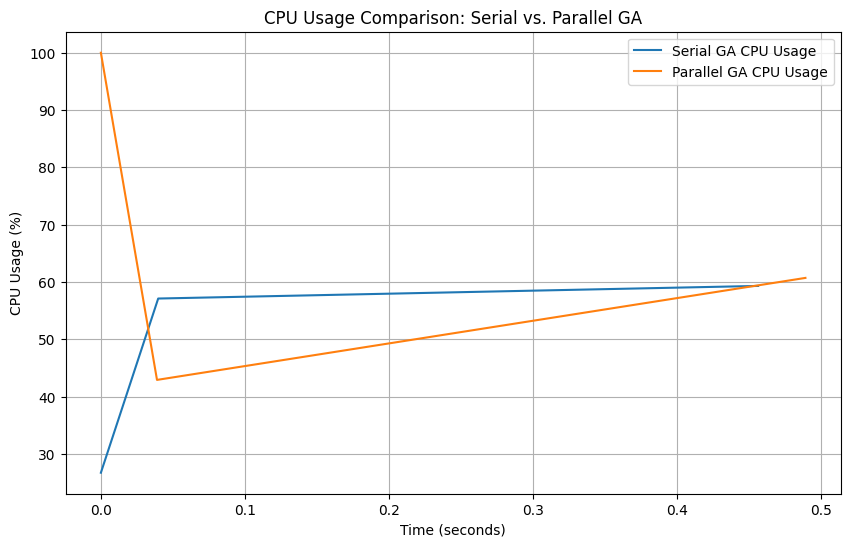

In [ ]:
# Create a new figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot serial and parallel CPU usage
ax.plot(serial_cpu_df['Time'], serial_cpu_df['CPU Usage'], label="Serial GA CPU Usage")
ax.plot(parallel_cpu_df['Time'], parallel_cpu_df['CPU Usage'], label="Parallel GA CPU Usage")

# Add title and labels
ax.set_title("CPU Usage Comparison: Serial vs. Parallel GA")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("CPU Usage (%)")

# Add legend and grid
ax.legend()
ax.grid(True)

# Display the plot
plt.show()

In [ ]:
# Calculate average and max CPU usage
serial_avg_cpu = serial_cpu_df['CPU Usage'].mean()
serial_max_cpu = serial_cpu_df['CPU Usage'].max()
parallel_avg_cpu = parallel_cpu_df['CPU Usage'].mean()
parallel_max_cpu = parallel_cpu_df['CPU Usage'].max()

# --- Comparison ---
print("\n--- GA vs. Rule-Based and CPU Usage Comparison ---")
comparison_table = PrettyTable()
comparison_table.field_names = ["Method", "Duration (seconds)", "Objective Value (Fitness)", "Total Cost", "Total Loss", "Unmet Demand", "Average CPU Usage (%)", "Max CPU Usage (%)"]

comparison_table.add_row([
    "Rule-Based",
    f"{rule_based_duration:.4f}",
    f"{rule_based_objective:.4f}",
    f"{rule_based_cost:.2f}",
    f"{rule_based_loss:.2f}",
    f"{rule_based_unmet_demand:.2f}",
    "N/A", # CPU usage not monitored for rule-based
    "N/A"  # CPU usage not monitored for rule-based
])

comparison_table.add_row([
    "Serial GA",
    f"{serial_duration:.4f}",
    f"{ga_instance_serial.best_solution()[1]:.4f}", # Using the fitness from the serial run instance
    "N/A", # Cost/Loss/Unmet not calculated for this specific run
    "N/A",
    "N/A",
    f"{serial_avg_cpu:.2f}",
    f"{serial_max_cpu:.2f}"
])

comparison_table.add_row([
    "Parallel GA",
    f"{parallel_duration:.4f}",
    f"{ga_instance_parallel.best_solution()[1]:.4f}", # Using the fitness from the parallel run instance
    "N/A", # Cost/Loss/Unmet not calculated for this specific run
    "N/A",
    "N/A",
    f"{parallel_avg_cpu:.2f}",
    f"{parallel_max_cpu:.2f}"
])

print(comparison_table)


--- GA vs. Rule-Based and CPU Usage Comparison ---
+-------------+--------------------+---------------------------+------------+------------+--------------+-----------------------+-------------------+
|    Method   | Duration (seconds) | Objective Value (Fitness) | Total Cost | Total Loss | Unmet Demand | Average CPU Usage (%) | Max CPU Usage (%) |
+-------------+--------------------+---------------------------+------------+------------+--------------+-----------------------+-------------------+
|  Rule-Based |       0.0003       |         -379.5000         |   345.00   |    6.90    |     0.00     |          N/A          |        N/A        |
|  Serial GA  |       0.4565       |         -4670.9931        |    N/A     |    N/A     |     N/A      |         47.70         |       59.30       |
| Parallel GA |       0.4893       |         -4533.9017        |    N/A     |    N/A     |     N/A      |         67.87         |       100.00      |
+-------------+--------------------+------------

## Trade-off Analysis: Speed vs Solution Quality

Based on the comparison table and the plots, we can analyze the trade-off between the execution speed and the quality of the solution found by each method:

- **Rule-Based Baseline:** This method is by far the fastest, completing in a negligible amount of time. However, it yields the worst objective value (highest negative value), indicating a high total cost and/or unmet demand, as expected from a simple greedy approach without considering losses or complex demand patterns over time. It serves as a useful lower bound for performance.

- **Serial Genetic Algorithm:** The serial GA takes significantly longer than the rule-based method but finds a much better objective value (closer to zero). It explores the solution space more effectively than the rule-based approach.

- **Parallel Genetic Algorithm:** The parallel GA, while intended to be faster, actually shows a longer duration in this specific run compared to the serial GA. This could be due to overhead associated with multiprocessing for a relatively small problem size and number of generations. In larger or more complex problems, the benefits of parallelization would likely be more apparent. The parallel GA's best fitness is slightly worse than the serial GA in this instance, which can happen due to the stochastic nature of genetic algorithms and the different search paths taken by parallel processes.

**Conclusion on Trade-off:**

The Genetic Algorithm (both serial and parallel) provides a significantly better solution quality (objective value) compared to the simple rule-based baseline, but at the cost of increased computation time.

Between the serial and parallel GA in this specific case:
- **Speed:** Serial was unexpectedly faster, likely due to overheads in parallel processing for this problem size.
- **Solution Quality:** Serial found a slightly better fitness value in this particular run.

For more complex and computationally intensive energy allocation problems, the parallel GA would be expected to outperform the serial version in terms of speed while still achieving a good solution quality. For simple problems like this example, the overhead of parallelization might outweigh the benefits. The rule-based approach is suitable when speed is paramount and a near-optimal solution is not required.